In [1]:
import numpy as np 
import pandas as pd 
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import re
import random

In [ ]:
nltk.download()

In [2]:
df_train = pd.read_csv("drugsComTrain_raw.csv")
df_test = pd.read_csv("drugsComTest_raw.csv")
df_train['sentiment'] = df_train['rating'].apply(lambda x: 1 if x>5 else 0)
df_test['sentiment'] = df_test['rating'].apply(lambda x: 1 if x>5 else 0)

In [3]:
from tqdm import tqdm
lemmatizer=WordNetLemmatizer()

def clean_sentences(df):
    reviews = []

    for sent in tqdm(df['review']):
        
        #remove html content
        review_text = BeautifulSoup(sent).get_text()
            
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
    
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
    
        reviews.append(lemma_words)

    return(reviews)

In [4]:
from nltk.corpus import stopwords
stopword = stopwords.words('english')
negated_words = ['don',"don't",'ain','aren',"aren't",'couldn',"couldn't",
                 'didn',"didn't",'doesn',"doesn't",'hadn',"hadn't",'hasn',"hasn't",'haven',"haven't",'isn',"isn't",
                'against','no','not','no','mightn',"mightn't",'mustn',"mustn't",'needn',"needn't",'shan',"shan't",'shouldn',
                 "shouldn't",'wasn',"wasn't",'weren',"weren't",'won',"won't",'wouldn',"wouldn't"]
stop = []
for w in stopword:
    if w not in negated_words:
        stop.append(w)

In [5]:
def clean(sen):
    return [word for word in sen if word not in stop]

In [6]:
df_train['tokens'] = clean_sentences(df_train)
df_test['tokens'] = clean_sentences(df_test)

100%|███████████████████████████████████████████████████████████████████████████| 53766/53766 [00:55<00:00, 977.53it/s]


In [7]:
df_train['cleaned']= df_train['tokens'].apply(clean)
df_test['cleaned'] = df_test['tokens'].apply(clean)

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(df_train['review'])
test_vectors = vectorizer.transform(df_test['review'])

In [66]:
vectorizer_bi = TfidfVectorizer(ngram_range=(2,2))
train_vectors_bi = vectorizer_bi.fit_transform(df_train['review'])
test_vectors_bi = vectorizer_bi.transform(df_test['review'])

In [70]:
import time
from sklearn import svm
from sklearn.metrics import classification_report

# Perform classification with SVM, kernel=linear
classifier_linear = svm.LinearSVC(verbose=True)
t0 = time.time()
classifier_linear.fit(train_vectors, df_train['sentiment'])
t1 = time.time()
prediction_train = classifier_linear.predict(train_vectors)
prediction_test = classifier_linear.predict(test_vectors)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1
# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))
report_train_uni = classification_report(df_train['sentiment'], prediction_train)
report_test_uni = classification_report(df_test['sentiment'], prediction_test)
cm_uni_train = metrics.confusion_matrix(df_train['sentiment'], prediction_train)
cm_uni_test = metrics.confusion_matrix(df_test['sentiment'], prediction_test)
#print('positive: ', report['0'])
#print('negative: ', report['1'])
#print(report)
print("***************** SVM (UNIGRAMS)**************\n")
print("**************TRAINING REPORT ***************\n")
print(report_train_uni)
print("**************TESTING REPORT ***************\n")
print(report_test_uni)

[LibLinear]Training time: 8.302923s; Prediction time: 0.122057s
***************** SVM (UNIGRAMS)**************

**************TRAINING REPORT ***************

              precision    recall  f1-score   support

           0       0.87      0.79      0.83     48088
           1       0.91      0.95      0.93    113209

    accuracy                           0.90    161297
   macro avg       0.89      0.87      0.88    161297
weighted avg       0.90      0.90      0.90    161297

**************TESTING REPORT ***************

              precision    recall  f1-score   support

           0       0.80      0.72      0.76     16207
           1       0.88      0.92      0.90     37559

    accuracy                           0.86     53766
   macro avg       0.84      0.82      0.83     53766
weighted avg       0.86      0.86      0.86     53766



In [71]:
print(cm_uni_test)

[[11675  4532]
 [ 2978 34581]]


In [72]:
print(cm_uni_train)

[[ 38088  10000]
 [  5921 107288]]


In [68]:
classifier_linear = svm.LinearSVC(verbose=True)
t0 = time.time()
classifier_linear.fit(train_vectors_bi, df_train['sentiment'])
t1 = time.time()
prediction_train_bi = classifier_linear.predict(train_vectors_bi)
prediction_test_bi = classifier_linear.predict(test_vectors_bi)
t2 = time.time()
time_linear_train_bi = t1-t0
time_linear_predict_bi = t2-t1
# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train_bi, time_linear_predict_bi))
report_train = classification_report(df_train['sentiment'], prediction_train_bi)
report_test = classification_report(df_test['sentiment'], prediction_test_bi)
#print('positive: ', report['0'])
#print('negative: ', report['1'])
print("***************** SVM (BIGRAMS)**************\n")
print("**************TRAINING REPORT ***************\n")
print(report_train)
print("**************TESTING REPORT ***************\n")
print(report_test)

[LibLinear]Training time: 13.337307s; Prediction time: 0.209403s
***************** SVM (BIGRAMS)**************

**************TRAINING REPORT ***************

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     48088
           1       1.00      1.00      1.00    113209

    accuracy                           1.00    161297
   macro avg       1.00      1.00      1.00    161297
weighted avg       1.00      1.00      1.00    161297

**************TESTING REPORT ***************

              precision    recall  f1-score   support

           0       0.92      0.88      0.90     16207
           1       0.95      0.97      0.96     37559

    accuracy                           0.94     53766
   macro avg       0.93      0.92      0.93     53766
weighted avg       0.94      0.94      0.94     53766



In [63]:
from sklearn import metrics
train_Accuracy_bi = metrics.accuracy_score(df_train['sentiment'],prediction_train_bi)
test_Accuracy_bi = metrics.accuracy_score(df_test['sentiment'],prediction_test_bi)
print("Train accuracy:",train_Accuracy_bi)
print("Test accuracy: ",test_Accuracy_bi)

Train accuracy: 0.9013000861764323
Test accuracy:  0.8603392478518023


In [60]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.savefig("svm_roc.jpg")
    plt.show()
    

AUC: 0.82


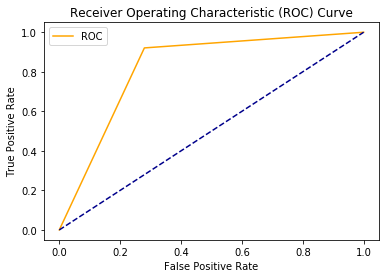

In [61]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
auc = roc_auc_score(df_test['sentiment'], prediction_test)
print('AUC: %.2f' % auc)

fpr, tpr, thresholds = roc_curve(df_test['sentiment'], prediction_test)

plot_roc_curve(fpr, tpr)

In [ ]:
plt.savefig("svm_roc.img")